### Extract Features from Tweets

#### Author: Lauren Thomas
#### Created: 05/07/2021
#### Last updated: 21/07/2021

###### File description: This file extracts features for the ML file from the Twitter data collected and pre-processed in clean_data


In [2]:
import os 
import pickle
import re
import spacy
import random
import time
import gzip
import gensim
import nltk

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gensim.corpora as corpora
import seaborn as sns


from os import sep
from pprint import pprint
from sklearn.model_selection import train_test_split
from gensim.models.wrappers import LdaMallet
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary
from gensim.parsing.porter import PorterStemmer

    

In [3]:
# Import stopwords
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['RT'])

# Load English tokenizer model from SPACY, disable parser, ner (for lemmatization)
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [4]:
# Working directory
cwd = f"C:{sep}Users{sep}ltswe{sep}Dropbox{sep}Oxford{sep}Thesis"

# Data directory
data_dir = f'D:'

In [5]:
# Path to mallet binary for the model generation
path_to_mallet_binary = f"C:{sep}mallet-2.0.8{sep}bin{sep}mallet"

In [ ]:
# First, separate the census tracts into train/test/validate data 
# Bring in tweet data
all_tweets = pd.DataFrame()
tweet_gdf_list = ["tweet_gdf_01", "tweet_gdf_02", "tweet_gdf_03", "tweet_gdf_04", "tweet_gdf_05", 
                  "tweet_gdf_06", "tweet_gdf_07", "tweet_gdf_08", "tweet_gdf_09", "tweet_gdf_10",
                  "tweet_gdf_11", "tweet_gdf_12"]
for df in tweet_gdf_list:
    print(f'Unpickling {df}')
    tweet_df = pickle.load(open(f'{data_dir}{sep}pickle{sep}{df}.pickle', 'rb'))
    all_tweets = all_tweets.append(tweet_df).reset_index(drop=True)

# Bring in label dataframe
labels_gdf = pickle.load(open(f'{data_dir}{sep}pickle{sep}labels_gdf.pickle', 'rb'))

In [ ]:
# Drop the census tracts where gentrification couldn't be estimated due to missing data
labels_gdf = labels_gdf.dropna().reset_index(drop=True).rename(columns={'fips_code': 'LocationCT'})

In [ ]:
# Sep into train/validate/test
train_labels, testval_labels = train_test_split(labels_gdf, test_size=0.3, random_state=0)
test_labels, val_labels = train_test_split(testval_labels, test_size = 0.5, random_state = 0)

In [ ]:
tweets_train_df = all_tweets.merge(train_labels, on='LocationCT')
tweets_test_df = all_tweets.merge(test_labels, on='LocationCT')
tweets_val_df = all_tweets.merge(val_labels,on='LocationCT')


In [ ]:
# Pickle the English language tweets
english_tweets_train = tweets_train_df[tweets_train_df['lang'] == 'en']
english_tweets_test = tweets_test_df[tweets_test_df['lang'] == 'en']
english_tweets_val = tweets_val_df[tweets_val_df['lang'] == 'en']


# pickle 
pickle.dump(english_tweets_train, open(f'{data_dir}{sep}pickle{sep}english_tweets_train.pickle', 'wb'))
pickle.dump(english_tweets_test, open(f'{data_dir}{sep}pickle{sep}english_tweets_test.pickle', 'wb'))
pickle.dump(english_tweets_val, open(f'{data_dir}{sep}pickle{sep}english_tweets_val.pickle', 'wb'))


In [ ]:
# Take random 20% sample of English lang tweets in the training set to use in topic modeller
sample_tweets = tweets_train_df[tweets_train_df['lang'] == 'en'].sample(n=int(round(0.2*len(tweets_train_df[tweets_train_df['lang'] == 'en']),0)),
                                                                        random_state=42)

In [ ]:
# First, make text into one long list where each var is a sentence
# Make the texts in English tweets into one long list
sample_tweet_list = sample_tweets['text'].tolist()

In [ ]:
# Next, collate the texts for tweets so that every year-month and census tract is its own document

# Create list of year-month pairs and census tracts
ym_list = [year_month for year_month in sample_tweets['ym'].unique()]
ct_list = [census_tract for census_tract in sample_tweets['LocationCT'].unique()]
year_list = ['2011', '2012', '2013']

collated_tweet_list = []
tst_ct = sample_tweets['LocationCT'].unique()[0:2]

for ym in ym_list:
    print(ym)
    for census_tract in ct_list:
        tweet_string = " ".join([tweet for tweet in sample_tweets[(sample_tweets['ym'] == ym) &
                       (sample_tweets['LocationCT'] == census_tract)]['text']])
        if tweet_string == "":
            continue
        collated_tweet_list.append(tweet_string)
        

len(collated_tweet_list)

In [ ]:
# pickle 
pickle.dump(sample_tweet_list, open(f'{data_dir}{sep}pickle{sep}sample_tweet_list.pickle', 'wb'))
pickle.dump(collated_tweet_list, open(f'{data_dir}{sep}pickle{sep}collated_tweet_list.pickle', 'wb'))

In [ ]:
sample_tweet_list = pickle.load(open(f'{data_dir}{sep}pickle{sep}sample_tweet_list.pickle', 'rb'))
collated_tweet_list = pickle.load(open(f'{data_dir}{sep}pickle{sep}collated_tweet_list.pickle', 'rb'))


In [ ]:
# Number of tweets in training set
print('Number of tweets in training set:',len(tweets_train_df[tweets_train_df['lang'] == 'en']))
# # in random sample
print('Number of tweets in 20% random sample:', len(sample_tweet_list))

In [ ]:
# Generate functions that will be used in the preprocessing of the tweets

# Create function that checks for any word that begins with certain chars in string passed then returns string without those words
def check_for_word(check_list, string):
    # Check list = list of strings that we do not want to begin any word in our passed string (e.g. http, @, [pic])
    for check in check_list:
        if check in string:
            # Split splits string on whitespace to words, filter gets rid of any word beginning w/the relevant chars, join joins them again with whitespace in between
            string = " ".join(filter(lambda x:x[0:len(check)]!=check, string.split()))
    return string

# Create function to clean up each tweet (get rid of emojis, URLs, etc.)
def sent_to_words(tweet_list):
    for tweet in tweet_list:
        # Check for URLs or [pic] (indicating picture?) or @ or any stopword-- if it exists, delete them.
        tweet = check_for_word(['http', '[pic]', '@'], tweet)
        # Remove new line characters
        tweet = re.sub('\n', ' ', tweet)
        yield(gensim.utils.simple_preprocess(str(tweet), deacc=True))
        
# Make function to remove stopwords 
def remove_stopwords(tweet_words):
    return [[word for word in tweet if word not in stop_words] for tweet in tweet_words]

# Make functions to lemmatize data
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [ ]:
# Now, create function that preprocesses the data given a list, where every item in the list = a document
# and the entire list = a corpus. Returns the dictionary & corpus
def preprocess_tweet_data(tweet_list, lemma_pickle):
    print('starting preprocessing...')
    # Clean up tweets
    tweet_words = list(sent_to_words(tweet_list))
    print('tweets cleaned!')
    
    # Remove stopwords
    tweets_nostops = remove_stopwords(tweet_words)
    print('stopwords removed!')
    
    # Create lemmatized data
    tweets_lemmatized = lemmatization(tweets_nostops, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
    print('tweets are lemmatized!')
    
    # Create corpus for use in topic modeller
    id2word = corpora.Dictionary(tweets_lemmatized)
    texts = tweets_lemmatized
    
    # Pickle the lemmatized tweets
    pickle.dump(texts, open(f'{data_dir}{sep}pickle{sep}{lemma_pickle}.pickle', 'wb'))
    
    corpus = [id2word.doc2bow(text) for text in texts]
    print('corpus has been created!')

    # Print words with frequencies
    print([[(id2word[id], freq) for id, freq in cp] for cp in corpus[:4]])
    
    return id2word, corpus

In [ ]:
# Create corpus with tweets as individual documents
id2word_ind, corpus_ind = preprocess_tweet_data(sample_tweet_list, "sample_tweets_lemmatized")

# # Create corpus with tweets per year-month & census tract as document
id2word_col, corpus_col = preprocess_tweet_data(collated_tweet_list, "collated_tweets_lemmatized")

In [ ]:
# # pickle corpus & dictionary
# pickle.dump(id2word_ind, open(f'{data_dir}{sep}pickle{sep}id2word_ind.pickle', 'wb'))
# pickle.dump(corpus_ind, open(f'{data_dir}{sep}pickle{sep}corpus_ind.pickle', 'wb'))

# pickle.dump(id2word_col, open(f'{data_dir}{sep}pickle{sep}id2word_col.pickle', 'wb'))
# pickle.dump(corpus_col, open(f'{data_dir}{sep}pickle{sep}corpus_col.pickle', 'wb'))

In [100]:
# # Unpickle individual corpus
# id2word_ind = pickle.load(open(f'{data_dir}{sep}pickle{sep}id2word_ind.pickle', 'rb'))
# corpus_ind = pickle.load(open(f'{data_dir}{sep}pickle{sep}corpus_ind.pickle', 'rb'))

# Unpickle collated corpus
id2word_col = pickle.load(open(f'{data_dir}{sep}pickle{sep}id2word_col.pickle', 'rb'))
corpus_col = pickle.load(open(f'{data_dir}{sep}pickle{sep}corpus_col.pickle', 'rb'))

In [8]:
# Create a function that trains LDA models using several diff num of topics, then pick the one with the best coherence

def find_cv(num_topic_list, corpus, id2word, save_as, plot=True):
    '''num_topic_list = list of number of topics you want to run through/train'''

    #Create a dict that will have num of topics as key and coherency score as value
    coh_dict = dict()


    # Create model with various numbers of topics
    for num_topic in num_topic_list:
        start = time.time()
        model = LdaMallet(path_to_mallet_binary, corpus=corpus, num_topics=num_topic, id2word=id2word)
        cm = CoherenceModel(model=model, corpus=corpus, coherence='u_mass')
        coh_dict[num_topic] = cm.get_coherence()
        print(num_topic, "topics coherence:", cm.get_coherence())
        print('Time Required:', round(time.time()-start,2), 'seconds')
        
    
    # Print Model topics
    model.print_topics()
        
    # Plot # of topics against coherence
    if plot==True:
        x,y = [num for num in coh_dict.keys()], [coh_value for coh_value in coh_dict.values()]
        sns.lineplot(x=x,y=y,marker='o')
        plt.title('Number of Topics vs. Coherence Scores')
        plt.xlabel('Number of Topics')
        plt.ylabel('Coherence Score')
        plt.show()
    
        plt.savefig(f'{cwd}{sep}figures{sep}{save_as}.jpg')
        
    return coh_dict


1 topics coherence: -1.3057131175757322
Time Required: 385.52 seconds
10 topics coherence: -1.6557797495710762
Time Required: 680.45 seconds
20 topics coherence: -1.7985931814455705
Time Required: 508.02 seconds
30 topics coherence: -1.9246228824060674
Time Required: 646.53 seconds
50 topics coherence: -1.9331855371134445
Time Required: 579.93 seconds


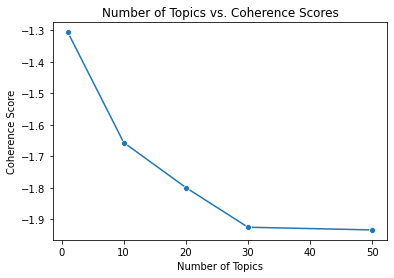

<Figure size 432x288 with 0 Axes>

In [8]:
# coh_dict_individual = find_cv([1,5,10,20,30], corpus_ind, id2word_ind, 'num_topics_coh_individual')

coh_dict_collated = find_cv([1,10,20,30,50], corpus_col, id2word_col, 'num_topics_coh_collated')

In [9]:
### Filter out extreme words to improve CV

In [9]:
# Define a function to find out some important information about a corpus
def report_info(dictionary, corpus):
    # Input: dictionary created in preprocess_tweet_data
    # Find # of docs
    num_docs = dictionary.num_docs
    # Find # of total words (not unique words) in the document
    num_words = dictionary.num_pos
    print('Number of documents:', num_docs)
    print('Number of total words:', num_words)
    
    # Find unique number of words

    # Make list of all word ids that appear in corpus
    word_ids = []
    for i in corpus:
        for j in i:
            word_ids.append(j[0])

    # To find the unique # of words, find the max of the word id list
    num_unique_words = max(word_ids)+1
    print('Number of unique words:', num_unique_words)
    
    return num_docs, num_words, num_unique_words

In [10]:
# Make index of word IDs
def make_freq_list(corpus, num_unique_words):
    word_index = [i for i in range(num_unique_words)]

    # Make list that will correspond to the number of times each word appears in whole corpus,
    # beginning with 0
    freq_list = [0 for i in range(len(word_index))]

    # # Loop through each word in the corpus, adding the # of times that word appears in the corpus 
    for doc in corpus:
        for word in doc:
            # word[0] = word index, word[1] = frequency in document (not in whole corpus). 
            # Add freq in document to count by word index in freq_list - will give us freq in whole doc
            freq_list[word[0]] += word[1]  
    
    # Zip word index and freq together to form list of tuples where x = index of word, y = freq in corpus
    word_freq = list(zip(word_index, freq_list))
    
    return word_index, freq_list, word_freq
        
    
    

In [11]:
# Find the number of documents that each word appears in
def find_docfreq(corpus, word_index):
    # corpus = relevant corpus, word_index = index of all unique words
    
    # Make list that will correspond to the number of documents each word appears in at least once,
    # beginning with 0
    freq_list = [0 for i in range(len(word_index))]
    
    # Loop through each word in the corpus, adding 1 if word appears in a particular doc
    for doc in corpus:
        for word in doc:
            # word[0] = word index. if word index appears in doc, add 1
            freq_list[word[0]] += 1
    
    doc_freq = list(zip(word_index, freq_list))
    
    return doc_freq, freq_list

In [12]:
def corpus2info(dictionary, corpus):
    # Combine the above functions to report info about corpus & return two tuples with (x,y) 
    # where x=word index, y= # of times word appeared in corpus in tuple 1 & x = word index, y=# of documents word appeared in at least once
    num_docs, num_words, num_unique_words = report_info(dictionary, corpus)
    
    word_index, freq_list, word_freq = make_freq_list(corpus, num_unique_words)
    
    doc_freq, doc_freq_list = find_docfreq(corpus, word_index) 
    print('\n')
    
    for qt in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]:
        print(f'The {str(int(qt*100))}th percentile document frequency is', np.quantile(doc_freq_list, qt))
        if qt == 0.8:
            eighty_percentile = int(round(np.quantile(doc_freq_list,qt),0))
        elif qt == 0.9:
            ninety_percentile = int(round(np.quantile(doc_freq_list,qt),0))
    print('The max document frequency is', max(doc_freq_list))
    return word_freq, doc_freq, eighty_percentile, ninety_percentile

In [13]:
word_freq, doc_freq, eighty_percentile, ninety_percentile = corpus2info(id2word_col, corpus_col)

Number of documents: 45277
Number of total words: 2953584
Number of unique words: 124037


The 10th percentile document frequency is 1.0
The 20th percentile document frequency is 1.0
The 30th percentile document frequency is 1.0
The 40th percentile document frequency is 1.0
The 50th percentile document frequency is 1.0
The 60th percentile document frequency is 1.0
The 70th percentile document frequency is 2.0
The 80th percentile document frequency is 3.0
The 90th percentile document frequency is 10.0
The max document frequency is 18518


In [79]:
# Make a histogram of document frequencies (# of docs that each word appears in)
doc_freq_list = []
for word in doc_freq:
    doc_freq_list.append(word[1])

# Get rid of the outliers
doc_freq_list2 = [i for i in doc_freq_list if i >4 and i < 350] 

# Plot histogram
_ = plt.hist(doc_freq_list2,bins=100)
plt.show()


In [28]:
# Filter out extremes from the corpus using the dictionary id2word
# no_below = 80th percentile of document frequency (gets rid of 80% of corpus)
# no_above = keep tokens contained in no more than _% of total corpus (recall, only 20% of corpus is left) 
# keep_n = 
# Create a function that will filter collated tweets using no_below, no_above
def filter_corpus_cv(no_below, no_above, save_as, cv_list = [1,10,20,30,50]):
    # Unpickle id2word_col & lemmatized texts
    id2word_col = pickle.load(open(f'{data_dir}{sep}pickle{sep}id2word_col.pickle', 'rb'))
    texts = pickle.load(open(f'{data_dir}{sep}pickle{sep}collated_tweets_lemmatized.pickle', 'rb'))
    
    # Filter id2word col using below & above
    id2word_col.filter_extremes(no_below=no_below, no_above=no_above)
    print('New number of unique words!:', len(id2word_col))
    
    # Create filtered corpus
    corpus_filtered = [id2word_col.doc2bow(text) for text in texts]
    
    # Try again w/filtered dict & corpus
    coh_dict_filtered = find_cv(cv_list, corpus_filtered, id2word_col, save_as)
    
    return coh_dict_filtered
    

New number of unique words!: 30111
1 topics coherence: -1.328398612301372
Time Required: 171.87 seconds
10 topics coherence: -1.8082372151812316
Time Required: 309.97 seconds
20 topics coherence: -1.9325511682558834
Time Required: 575.03 seconds
30 topics coherence: -2.0545184330267126
Time Required: 580.8 seconds
50 topics coherence: -2.081591285272688
Time Required: 666.73 seconds


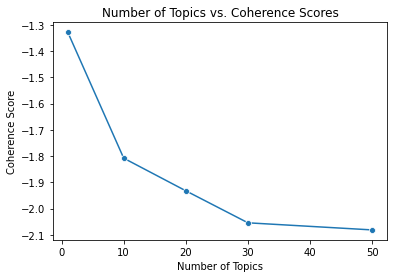

New number of unique words!: 13011
1 topics coherence: -1.4757665288353743
Time Required: 226.69 seconds
10 topics coherence: -1.9340616224705953
Time Required: 353.62 seconds
20 topics coherence: -2.034227095597798
Time Required: 351.09 seconds
30 topics coherence: -2.068819028074669
Time Required: 495.64 seconds
50 topics coherence: -2.1961135549632145
Time Required: 471.78 seconds


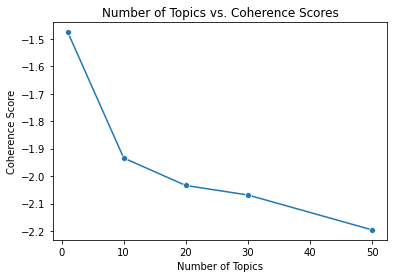

New number of unique words!: 12904
1 topics coherence: -1.9506765024361767
Time Required: 264.57 seconds
10 topics coherence: -2.2988930671900256
Time Required: 306.87 seconds
20 topics coherence: -2.3866667637483436
Time Required: 306.4 seconds
30 topics coherence: -2.4849970996908795
Time Required: 412.03 seconds
50 topics coherence: -2.5913054643428177
Time Required: 437.29 seconds


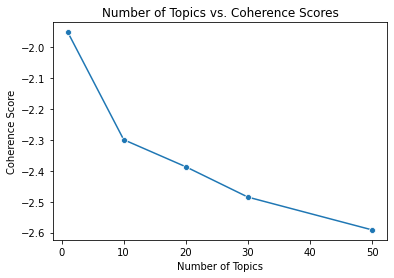

New number of unique words!: 29974
1 topics coherence: -1.9506765024361767
Time Required: 272.92 seconds
10 topics coherence: -2.2967902906393176
Time Required: 334.73 seconds
20 topics coherence: -2.4229822694218823
Time Required: 355.12 seconds
30 topics coherence: -2.5181656988269823
Time Required: 485.86 seconds
50 topics coherence: -2.5934808881486253
Time Required: 533.1 seconds


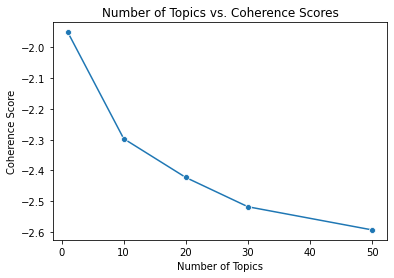

<Figure size 432x288 with 0 Axes>

In [19]:
coh_dict_filtered1 = filter_corpus_cv(no_below=eighty_percentile, no_above=.15, save_as = 'num_topics_coh_collated1')
coh_dict_filtered2 = filter_corpus_cv(no_below=ninety_percentile, no_above=.10, save_as = 'num_topics_coh_collated2')
coh_dict_filtered3 = filter_corpus_cv(no_below=ninety_percentile, no_above=.05, save_as = 'num_topics_coh_collated3')
coh_dict_filtered4 = filter_corpus_cv(no_below=eighty_percentile, no_above=.05, save_as = 'num_topics_coh_collated4')


New number of unique words!: 29974
1 topics coherence: -1.9506765024361767
Time Required: 142.48 seconds
2 topics coherence: -2.0075844244287455
Time Required: 147.21 seconds
3 topics coherence: -2.1780502513319306
Time Required: 162.0 seconds


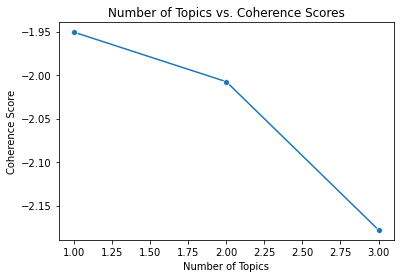

<Figure size 432x288 with 0 Axes>

In [23]:
coh_dict_filtered5 = filter_corpus_cv(no_below=eighty_percentile, no_above=.05, 
                                      save_as = 'num_topics_coh_collated5', 
                                     cv_list = [1,2,3])


New number of unique words!: 17772
1 topics coherence: -12.154102983901003
Time Required: 157.67 seconds
2 topics coherence: -13.544750648903555
Time Required: 106.82 seconds
3 topics coherence: -12.974349979759893
Time Required: 101.83 seconds
4 topics coherence: -13.591447733624598
Time Required: 133.86 seconds
5 topics coherence: -12.744595602862173
Time Required: 111.61 seconds
6 topics coherence: -13.35434911691335
Time Required: 124.38 seconds
7 topics coherence: -12.48369509100338
Time Required: 124.36 seconds
8 topics coherence: -11.694791518436588
Time Required: 101.87 seconds
9 topics coherence: -12.119672182846124
Time Required: 87.78 seconds
10 topics coherence: -11.62638089853145
Time Required: 70.01 seconds


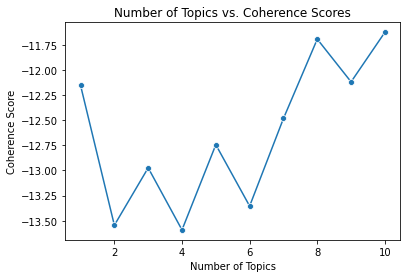

<Figure size 432x288 with 0 Axes>

In [30]:
coh_dict_filtered1 = filter_corpus_cv(no_below=5, no_above=100/45277, save_as = 'test_filtered',
                                     cv_list = [1,2,3,4,5,6,7,8,9,10])



New number of unique words!: 17772
1 topics coherence: -12.154102983901003
Time Required: 92.99 seconds
10 topics coherence: -11.526783824707456
Time Required: 86.11 seconds
20 topics coherence: -11.533152378192032
Time Required: 105.4 seconds
30 topics coherence: -11.094162864922337
Time Required: 102.89 seconds
50 topics coherence: -10.984455489447276
Time Required: 87.59 seconds
70 topics coherence: -10.897640018972059
Time Required: 93.19 seconds


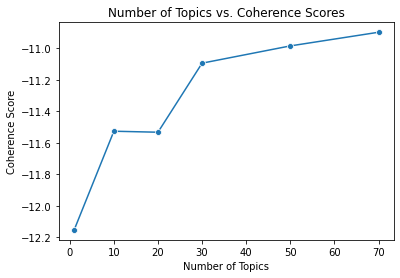

<Figure size 432x288 with 0 Axes>

In [31]:
coh_dict_filtered2 = filter_corpus_cv(no_below=5, no_above=100/45277, save_as = 'test_filtered2',
                                     cv_list = [1,10,20,30,50,70])

New number of unique words!: 21264
1 topics coherence: -13.070089359122898
Time Required: 78.56 seconds
10 topics coherence: -11.724767260710411
Time Required: 139.19 seconds
20 topics coherence: -11.410391112660683
Time Required: 89.03 seconds
30 topics coherence: -11.602260823164498
Time Required: 94.73 seconds
50 topics coherence: -11.247757760495409
Time Required: 149.61 seconds
70 topics coherence: -11.12262250978965
Time Required: 218.09 seconds


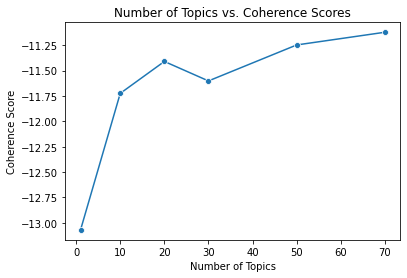

<Figure size 432x288 with 0 Axes>

In [32]:
coh_dict_filtered3 = filter_corpus_cv(no_below=4, no_above=100/45277, save_as = 'test_filtered3',
                                     cv_list =[1,10,20,30,50,70])

New number of unique words!: 17772
70 topics coherence: -10.9763778827396
Time Required: 120.65 seconds
90 topics coherence: -11.046728562670442
Time Required: 145.13 seconds
120 topics coherence: -10.809276214419233
Time Required: 110.6 seconds
150 topics coherence: -10.395049887702909
Time Required: 117.51 seconds


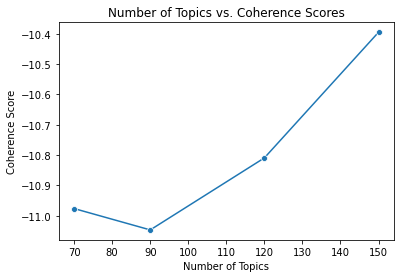

<Figure size 432x288 with 0 Axes>

In [33]:
coh_dict_filtered4 = filter_corpus_cv(no_below=5, no_above=100/45277, save_as = 'test_filtered4',
                                     cv_list = [70, 90, 120, 150])

New number of unique words!: 17772
150 topics coherence: -10.69553195988983
Time Required: 153.68 seconds
170 topics coherence: -10.29232821292004
Time Required: 159.58 seconds
250 topics coherence: -10.424704366993721
Time Required: 157.02 seconds
300 topics coherence: -10.768694738413783
Time Required: 237.04 seconds


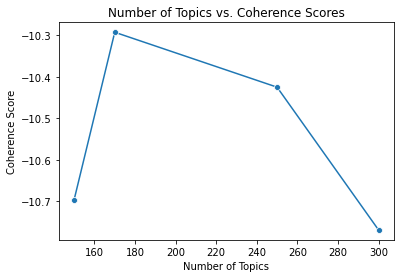

<Figure size 432x288 with 0 Axes>

In [35]:
coh_dict_filtered5 = filter_corpus_cv(no_below=5, no_above=100/45277, save_as = 'test_filtered5',
                                     cv_list = [150, 170, 250, 300])